# Case Study 1 : Yelp Data Analysis

**Required Readings:** 
* [Yelp Dataset Challenge](https://www.yelp.com/dataset_challenge) 
* Please download the Yelp dataset from the above webpage.

**NOTE**
* Please don't forget to save the notebook frequently when working in Jupyter Notebook, otherwise the changes you made can be lost.


Here is an example of the data format. More details are included [here](https://www.yelp.com/dataset_challenge)

## Business Objects

Business objects contain basic information about local businesses. The fields are as follows:

```json
{
  'type': 'business',
  'business_id': (a unique identifier for this business),
  'name': (the full business name),
  'neighborhoods': (a list of neighborhood names, might be empty),
  'full_address': (localized address),
  'city': (city),
  'state': (state),
  'latitude': (latitude),
  'longitude': (longitude),
  'stars': (star rating, rounded to half-stars),
  'review_count': (review count),
  'photo_url': (photo url),
  'categories': [(localized category names)]
  'open': (is the business still open for business?),
  'schools': (nearby universities),
  'url': (yelp url)
}
```
## Checkin Objects
```json
{
    'type': 'checkin',
    'business_id': (encrypted business id),
    'checkin_info': {
        '0-0': (number of checkins from 00:00 to 01:00 on all Sundays),
        '1-0': (number of checkins from 01:00 to 02:00 on all Sundays),
        ...
        '14-4': (number of checkins from 14:00 to 15:00 on all Thursdays),
        ...
        '23-6': (number of checkins from 23:00 to 00:00 on all Saturdays)
    }, # if there was no checkin for a hour-day block it will not be in the dict
}
```

# Problem: pick a data science problem that you plan to solve using Yelp Data
* The problem should be important and interesting, which has a potential impact in some area.
* The problem should be solvable using yelp data and data science solutions.

Please briefly describe in the following cell: what problem are you trying to solve? why this problem is important and interesting?

<b>The problem we are picking</b> 
<ol>We are trying to predict the star rating of the business objects based on customers' reviews. We want to find the connection between customers' comments and their star rating.</ol>
<b>Why important and interesting?</b>
<ol> It's an interesting problem because we want to figure out whether customers' reviews can reflect their expectations. While star rating implies the ranking we have for a particular service or things, our comments may reveal more information about what we feel and there may be a difference between our words and expectations. Therefore, it's important for the business objects to utilize the value of their customers' reviews and understand their customers' real needs.  </ol>

# Data Collection/Processing: 

In [2]:
# import packages and functions
import json
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from pandas import Series
from sklearn import metrics
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
import nltk
# nltk.download('punkt') 
# nltk.download('stopwords')
import string
from nltk import word_tokenize
from nltk.util import bigrams, trigrams
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import Counter

### Import "review.json" data and "business.json" data

<b><i>Note</i></b>: we extract 1000000 records from review file because review file is so large (more than 5.0 GB) and we cannot import it at one time (the processing time will also be quite long) so we take 1000000 records from review file for convenience and we think 1000000 records is enough for us to perform analysis on the connection between user's review and their star rating.

In [9]:
# access the file path of "business.json" file and "review.json" file and "checkin.json" from personal computer
review_file = '/Users/daojun/Documents/wpi_classes/ds501_IntrotoDS/Cases/case1/data_yelp/yelp_dataset/review.json' 
business_file = '/Users/daojun/Documents/wpi_classes/ds501_IntrotoDS/Cases/case1/data_yelp/yelp_dataset/business.json'
checkin_file='/Users/daojun/Documents/wpi_classes/ds501_IntrotoDS/Cases/case1/data_yelp/yelp_dataset/checkin.json'

In [4]:
# access "review.json" data
i = 0            
lines_num = 1000000
data_list = list(range(lines_num))         
with open(review_file) as r:            
    for line in r:                      
        data_list[i] = json.loads(line)
        i = i+1                         
        if i == lines_num:                 
            break                       
review = pd.DataFrame(data_list)

In [5]:
# access "business.json" data
with open(business_file) as f:
    business = pd.DataFrame(json.loads(line) for line in f)

In [10]:
# access "checkin.json" data
with open(checkin_file) as f:
    check = pd.DataFrame(json.loads(line) for line in f)

### Review Data Processing
Now, we want to remove all useless information in the text. We download the stopwords with nltk.download( ).
In the code below, stopwords.words('english') returns a list of lowercase stop words like "is, was, for," etc. We believe that those words have no useful information for classification. So we remove them as noise.

In [6]:
NLTK_STOPWORDS = set(stopwords.words('english'))

In [7]:
# define the stopwords remove function 
def remove_stopwords(s):
    token_list = nltk.word_tokenize(s)
    exclude_stopwords = lambda token : token not in NLTK_STOPWORDS
    return ' '.join(filter(exclude_stopwords, token_list))

def restring_tokens(token_list):
    return ' '.join(token_list)

def remove(s):
    s = remove_stopwords(s)
    token_list = nltk.word_tokenize(s)
    return restring_tokens(token_list)

In [15]:
review["text"] = review["text"].apply(remove)

# Data Exploration: Exploring the Yelp Dataset

**(1) Finding the most popular business categories:** 
* print the top 10 most popular business categories in the dataset and their counts (i.e., how many business objects in each category). Here we say a category is "popular" if there are many business objects in this category (such as 'restaurants').

In [71]:
bus = business['categories'].str.split(',', expand = True)
count_b = bus.apply(pd.Series.value_counts)
sum_b = count_b.apply(np.sum, axis = 1).astype('int')
print(sum_b.sort_values(ascending = False).head(10))

 Restaurants         41423
 Shopping            24087
 Food                21966
Restaurants          17948
 Home Services       14462
 Beauty & Spas       13538
 Health & Medical    12601
 Local Services      10519
 Nightlife           10382
 Bars                 9209
dtype: int64


** (2) Find the most popular business objects** 
* print the top 10 most popular business objects in the dataset and their counts (i.e., how many checkins in total for each business object).  Here we say a business object is "popular" if the business object attracts a large number of checkins from the users.

In [11]:
# split each checkin time and count for the number of times
check['times'] = check.date.str.split(',').apply(len)

In [14]:
# rank the top 10 most popular business objects
dfcheck = check[['business_id','times']]
dfcheck.sort_values(by = "times" , ascending = False).head(10)

,business_id,times
42142,FaHADZARwnY4yvlvpnsfGA,143061
52735,JmI9nslLD7KZqRr__Bg6NQ,123126
157953,yQab5dxZzgBLTEHCw9V7_w,54787
15955,5LNZ67Yw9RD6nf4_UhXOjw,46384
49667,IZivKqtHyz4-ts8KsnvMrA,38277
74469,SMPbvZLSMMb7KU76YNYMGg,34353
86134,Wxxvi3LZbHNIDwJ-ZimtnA,32343
130714,na4Th5DrNauOv-c43QQFvA,31185
83644,VyjyHoBg3KC5BSFRlD0ZPQ,30782
39989,El4FC8jcawUVgw_0EIcbaQ,30098


# The Solution: implement a data science solution to the problem you are trying to solve.

Briefly describe the idea of your solution to the problem in the following cell:

### Our main idea to solve the problem


To predict the star rating using the review data, we use the Bag of words model. This model can transform natural language into vectors. Each element in one vector corresponds to a unique word. We also use the TF-IDF method to take the importance of words into consideration.


### Our steps are below:

<ul>1. Divide the review dataset into training data and test data. </ul>

<ul>2. We use the function CountVectorize in scikit-learn package to fit the model using training data. </ul>

<ul>3. We predict the star rating and calculate the accuracy rate of our model using test data. </ul>

Write codes to implement the solution in python:

### Divide Review Dataset

In [16]:
# Divide review data into two different datasets: training data and test data.
# X presents review while y represents the star rating
n = 0.75
train_x = review['text'][0:int(lines_num * n)]
train_y = review['stars'][0:int(lines_num * n)]
test_x = review['text'][int(lines_num * n) + 1:]
test_y = review['stars'][int(lines_num * n) + 1:]

### Perform Bag of Words Model 

In [17]:
bag_of_words_vectorizer = CountVectorizer(analyzer = "word",
                                          tokenizer = None,    
                                          preprocessor = None,
                                          ngram_range = (1, 1),
                                          binary = False,
                                          strip_accents='unicode')

In [18]:
bow_feature_matrix_train = bag_of_words_vectorizer.fit_transform(train_x)
bow_feature_matrix_test = bag_of_words_vectorizer.transform(test_x)

In [19]:
multinomial_classifier_bow = MultinomialNB()
multinomial_classifier_bow.fit(bow_feature_matrix_train, train_y)
multinomial_prediction_bow = multinomial_classifier_bow.predict(bow_feature_matrix_test) 

In [20]:
# transform the type of test_y from Series to numpy.ndarray
test_y = test_y.values
print(type(test_y))

<class 'numpy.ndarray'>


### Overall accuracy rate of our model

In [21]:
# define an accuracy_prediction function to calculate the accuracy rate of our model's prediction 
def accuracy_prediction(y_real, y_predict):
    
    assert len(y_real) == len(y_predict)
    
    count = 0 
    for i in range(len(y_real)):
        if y_real[i] == y_predict[i]:
            count += 1
    
    accuracy = count / len(y_real)
    
    return accuracy

In [22]:
overall_acc_rate = accuracy_prediction(test_y, multinomial_prediction_bow)
overall_acc_rate

0.5966783867135469

# Results: summarize and visualize the results discovered from the analysis

Please use figures, tables, or videos to communicate the results with the audience.


In [23]:
# define a function to count the number of each star rating in datasets
def count_each_star_num(stars):
    count_1_star = 0
    count_2_star = 0
    count_3_star = 0
    count_4_star = 0
    count_5_star = 0
    for i in range(len(stars)):
        if stars[i] == 1:
            count_1_star += 1
        if stars[i] == 2:
            count_2_star += 1
        if stars[i] == 3:
            count_3_star += 1
        if stars[i] == 4:
            count_4_star += 1
        if stars[i] == 5:
            count_5_star += 1
    return [count_1_star, count_2_star, count_3_star, count_4_star, count_5_star]

In [24]:
def precision_rate_each_star(y_real, y_predict, count_star_list):
    
    assert len(y_real) == len(y_predict)
    
    count_star_1 = 0
    count_star_2 = 0
    count_star_3 = 0
    count_star_4 = 0
    count_star_5 = 0
    
    for i in range(len(y_real)):
        if y_real[i] == 1 and y_real[i] == y_predict[i]:
            count_star_1 += 1
        if y_real[i] == 2 and y_real[i] == y_predict[i]:
            count_star_2 += 1
        if y_real[i] == 3 and y_real[i] == y_predict[i]:
            count_star_3 += 1
        if y_real[i] == 4 and y_real[i] == y_predict[i]:
            count_star_4 += 1
        if y_real[i] == 5 and y_real[i] == y_predict[i]:
            count_star_5 += 1

    accuracy_1 = count_star_1 / count_star_list[0]
    accuracy_2 = count_star_2 / count_star_list[1]
    accuracy_3 = count_star_3 / count_star_list[2]
    accuracy_4 = count_star_4 / count_star_list[3]
    accuracy_5 = count_star_5 / count_star_list[4]
    
    return [accuracy_1, accuracy_2, accuracy_3, accuracy_4, accuracy_5]

In [26]:
# we count the number of each star rating in test data. 
count_star_num = count_each_star_num(test_y)
count_star_num

[36128, 20030, 27429, 55499, 110913]

In [29]:
precision_rate_list = precision_rate_each_star(test_y, multinomial_prediction_bow, count_star_num)
precision_rate_list

[0.7030281222320638,
 0.3019970044932601,
 0.36968172372306685,
 0.6116146236869133,
 0.66391676358948]

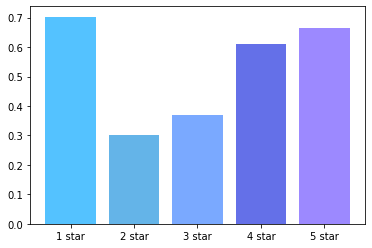

In [47]:
names_list = ['1 star','2 star', '3 star', '4 star', '5 star']
plt.bar(range(len(precision_rate_list)), precision_rate_list, color=['#54C2FF','#64B4E8','#7AA9FF','#6470E8', '#9C89FF'], tick_label = names_list)
plt.rcParams['axes.facecolor'] = 'white'
plt.show()

### Calculate the Average Star Rating

In this step, we calculate the average star rating based on our prediction and compare it with the actual average star rating in "business.json" file.

In [48]:
# inner join of review file and business file on key "business_id"
df_review_and_business = pd.merge(business, review, on="business_id", how="inner")

In [49]:
pre_avg_star_rating = df_review_and_business['stars_y'].groupby(df_review_and_business['business_id']).mean()
actual_avg_star_rating = df_review_and_business['stars_x'].groupby(df_review_and_business['business_id']).mean()
y_hat = actual_avg_star_rating - pre_avg_star_rating

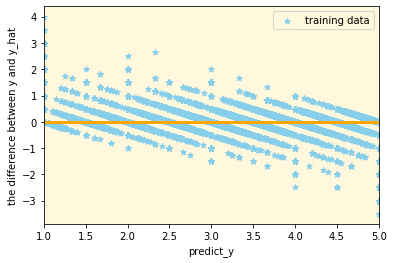

In [52]:
plt.scatter(pre_avg_star_rating, y_hat, c = "skyblue", marker="*",label="training data")
plt.legend(loc = "upper right")
plt.hlines(y = 0, xmin = -10,xmax = 50,lw = 3,color="orange")
plt.xlim([1,5])
plt.xlabel("predict_y")
plt.ylabel("the difference between y and y_hat")
plt.rcParams['axes.facecolor'] = 'cornsilk'
plt.show()

### Explore Review Data and Visulizatoin

In [53]:
# transform review to .txt file
review['text'][0:lines_num].to_frame().to_csv(r'review.txt', header=None, index=None, sep=' ', mode='a')

We create a wordcloud map to see which words in user's review are most frequent

In [55]:
file_path = 'review.txt'
background_file_path = 'bg_file.png'

In [56]:
def wordcloud_review(file_path, bg_file_path):
    text = open(file_path,'r').read()
    bg_pic = np.array(Image.open(bg_file_path))
    wordcloud = WordCloud(
        width = 1000,
        height = 1000,
        mask = bg_pic,
        background_color = 'lavender',
        max_words = 100, # extract top 100 frequent words from review
        scale = 1.5).generate(text)
    wordcloud.to_file('wordcloud.png')
    plt.imshow(wordcloud)
    width = 10
    height = 10
    plt.axis('off')
    plt.show()

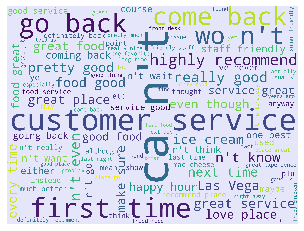

In [57]:
wordcloud_review(file_path, background_file_path)

Besides, we create a bar plot to see the distribution of star rating

In [58]:
def star_distribution_plot(star_list):
    names_list = ['1 star','2 star', '3 star', '4 star', '5 star']
    plt.bar(range(len(star_list)), star_list, color = ['#54C2FF','#64B4E8','#7AA9FF','#6470E8', '#9C89FF'], tick_label = names_list)
    plt.rcParams['axes.facecolor']='white'
    plt.show()

In [59]:
each_star_num = count_each_star_num(review['stars'])
each_star_num

[148519, 80458, 109804, 219363, 441856]

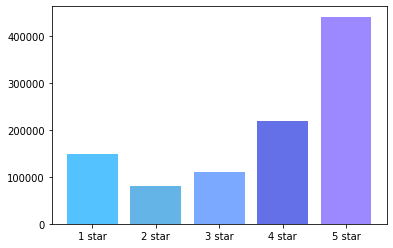

In [61]:
star_distribution_plot(each_star_num)

### Further explaination of the results 

What we find: 

<ol>From the results of our model, we find that the accuracy rate of one star, four stars and five stars is relatively high, but the accuracy rate of the 2 and 3-stars rating is relatively low. </ol>


We propose two possible explainations for this phenomenon:


1. From the wordcloud graph we create before, we can see some words that appear in high frequency like "pretty good", "highly recommended" . Those words have high sentimental tendency to express whether we like something or not. So we guess that those who give high star rating (4 or 5 star) tend to use some positive words. And our Bag of Words model can capture these words. Thus, our prediction is more accurate on star rating 4 or star rating 5. The same thing applies to the star rating one. People may tend to use negative words to describe their bad experiences. But for star rating 2 or 3, they may not directly use these words to express how they feel.   


2. From the bar plot of the distribution of star ratings, we find that the number of star rating 1 and 4 and 5 is high and it means that we have more data source on these star ratings so we have more data on these star ratings to train our model which leads to high accuracy rate.
